In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import helperfns

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from data.PDEsolvers import Burgers_Periodic

In [2]:
# User inputs
data_name = 'Burgers_Eqn_exp28'  # Prefix of data files

# Inputs to the network:

Note: the data has shape: (len_time, num_examples, state_dimension)

1. The 3D tensor with the data (no stacking required) - for autoencoder and outer autoencoder losses
2. A 3D tensor for prediction: (len_time-num_shifts, num_examples, state_dimension)
3. A 3D tensor for linearity loss: (len_time-num_shifts_middle, num_examples, state_dimension)

# Outputs of the network:

1. The 3D tensor with the data - for autoencoder loss
2. The 3D tensor with the predictions: (num_shifts, (len_time-num_shifts)*num_examples, state_dimension) 
3. The 3D tensor with the data - for outer autoencoder loss

# Internal Losses

1. Inner autoencoder - Can do with the original data
2. Linearity loss - Need to stack internally: match prediction but with num_shifts_middle

# New Strategy

## Inputs to the network
1. 3D tensor with shape (num_examples, len_time, state_dimension)

## Outputs to the newtork
1. 3D tensor with autoencoder output with shape (num_examples, len_time, state_dimension)
2. 3D tensor with outer autoencoder output with shape (num_examples, len_time, state_dimension)
3. 3D tensor with predictions with shape (num_shifts, (len_time-num_shifts)*num_examples, state_dimension)

Does 3 need to change to (num_examples, num_shifts*(len_time-num_shifts), state_dimension)?
The order of the middle index will be [shift1_results, shift2_results, shift3_restuls,...]

## Internal Losses
1. 3D tensor with inner autoencoder output with shape (num_examples, len_time, latent_dimension)
2. 3D tensor with linearity predictions with shape (num_shifts_middle, (len_time-num_shifts_middle)*num_examples, latent_dimension)

For 1, need to reshape back to 3D
For 2, do we need to reshape like for predictions above?

In [3]:
from matplotlib.collections import LineCollection

# Waterfall plot function
def waterfall_plot(fig,ax,X,Y,Z,time_in=0,time_out=1,**kwargs):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
        kwargs : kwargs are directly passed to the LineCollection object
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)  
        # The values used by the colormap are the input to the array parameter
        if j == time_in:
            cmap = matplotlib.colors.ListedColormap(['red'])
            #ax.plot(X[j,:],Y[j,:],Z[j,:],'-r',linewidth=2,alpha=1,zorder=2)
        elif j == time_out:
            cmap = matplotlib.colors.ListedColormap(['blue'])
            #ax.plot(X[j,:],Y[j,:],Z[j,:],'-b',linewidth=2,alpha=1,zorder=2)
        else:
            cmap = matplotlib.colors.ListedColormap([[0.5,0.5,0.5]])
        lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    #fig.colorbar(lc) # add colorbar, as the normalization is the same for all
    # it doesent matter which of the lc objects we use
    ax.auto_scale_xyz(X,Y,Z) # set axis limits

In [4]:
data_file = "./data/{}_train1_x.npy".format(data_name)
data_tensor = np.load(data_file)

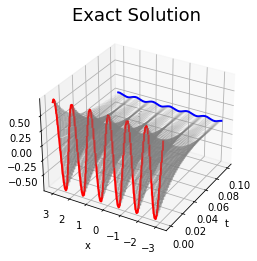

In [5]:
# Inputs
T_end = 0.1
IC = 1  # index of initial condition

# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, T_end, 51)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[IC,:,:]

fig = plt.figure(figsize=(13,4)) 

ax = fig.add_subplot(1, 1, 1, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=50,linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Exact Solution', fontsize=18)

plt.show()

In [6]:
print(data_tensor.shape)

(6000, 51, 128)


In [7]:
# Reduce size for testing
inputs = data_tensor[:8,:,:]
print(inputs.shape)

(8, 51, 128)


In [8]:
# Create new stack_predictions that will give shape (num_examples, (len_time-num_shifts)*num_shifts, state_dimension)
# input shape is (num_examples, len_time, state_dimension)

def stack_predictions(data, num_shifts):
    len_pred = data.shape[1]-num_shifts
    prediction_tensor = np.zeros([data.shape[0], len_pred*num_shifts, data.shape[-1]])
    for j in range(num_shifts):
        prediction_tensor[:,j*(len_time-num_shifts):(j+1)*(len_time-num_shifts),:] = data[:,j+1:j+1+len_pred,:]
            
    return prediction_tensor

In [9]:
# Test for predictions:
len_time = 51
num_shifts = 10
pred_inputs = inputs[:,:len_time-num_shifts,:]
print(pred_inputs.shape)
original_inputs = pred_inputs

(8, 41, 128)


In [10]:
def reshape_inputs(inputs):
    input_list = []
    for data in inputs:
        input_list.append(np.reshape(data, [-1, data.shape[-1]]))
    return tuple(input_list)

_, pred_inputs, _ = reshape_inputs((inputs, pred_inputs, inputs))
print(pred_inputs.shape)

(328, 128)


In [ ]:
predictions = np.zeros([inputs.shape[0],
                        (len_time-num_shifts)*num_shifts,
                        128])
current = pred_inputs
advanced = np.zeros(current.shape)
for shift in range(num_shifts):
    print(shift)
    for row in range(current.shape[0]):
        u0 = current[row,:]
        advanced_row = Burgers_Periodic(mu=1, eps=10, x=x_pts, t_output=t_pts[:2], dt_factor=1000, u_k=u0)
        advanced[row,:] = advanced_row[-1,:]
    predictions[:,shift*(len_time-num_shifts):(shift+1)*(len_time-num_shifts),:] = np.reshape(advanced, [inputs.shape[0], len_time-num_shifts,128])
    current = advanced
    
print(predictions.shape)

0
1
2
3
4


In [ ]:
exact = stack_predictions(inputs, num_shifts)
print(exact.shape)

In [ ]:
print(np.linalg.norm(predictions))
print(np.linalg.norm(exact))
print(np.linalg.norm(predictions-exact))
print(np.linalg.norm(predictions-exact)/np.linalg.norm(exact))

In [ ]:
loss_weights = [1,2,3,4,5]
print([loss_weights[i] for i in [0,2,3]])

In [ ]:
# Try again without using first dimension

def new_stack_predictions(data, num_shifts):
    len_pred = data.shape[1]-num_shifts
    prediction_list = []
    for j in range(num_shifts):
        prediction_list.append(data[:,j+1:j+1+len_pred,:])
    prediction_tensor = tf.concat(prediction_list, axis=1)
    
    return prediction_tensor

In [ ]:
# Test for predictions:
len_time = 51
num_shifts = 10
pred_inputs = inputs[:,:len_time-num_shifts,:]
print(pred_inputs.shape)
original_inputs = pred_inputs

In [ ]:
def reshape_inputs(inputs):
    input_list = []
    for data in inputs:
        input_list.append(np.reshape(data, [-1, data.shape[-1]]))
    return tuple(input_list)

_, pred_inputs, _ = reshape_inputs((inputs, pred_inputs, inputs))
print(pred_inputs.shape)

In [ ]:
predictions_list = []
current = pred_inputs
advanced = np.zeros(current.shape)
for shift in range(num_shifts):
    print(shift)
    for row in range(current.shape[0]):
        u0 = current[row,:]
        advanced_row = Burgers_Periodic(mu=1, eps=10, x=x_pts, t_output=t_pts[:2], dt_factor=1000, u_k=u0)
        advanced[row,:] = advanced_row[-1,:]
    predictions_list.append(np.reshape(advanced, [-1, len_time-num_shifts,128]))
    current = advanced
predictions = np.concatenate(predictions_list, axis=1)
    
print(predictions.shape)

In [ ]:
exact = new_stack_predictions(inputs, num_shifts)
print(exact.shape)

In [ ]:
print(np.linalg.norm(predictions))
print(np.linalg.norm(exact))
print(np.linalg.norm(predictions-exact))
print(np.linalg.norm(predictions-exact)/np.linalg.norm(exact))